In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')


In [2]:
import pandas as pd

df = pd.read_csv('Telco-Customer-Churn.csv')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [3]:

df.drop('customerID', axis=1, inplace=True)
# Convert 'TotalCharges' to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with any missing values
df.dropna(inplace=True)

label_encoder = LabelEncoder()
for column in df.select_dtypes(include='object').columns:
    if column != 'Churn':  
        df[column] = label_encoder.fit_transform(df[column])

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})


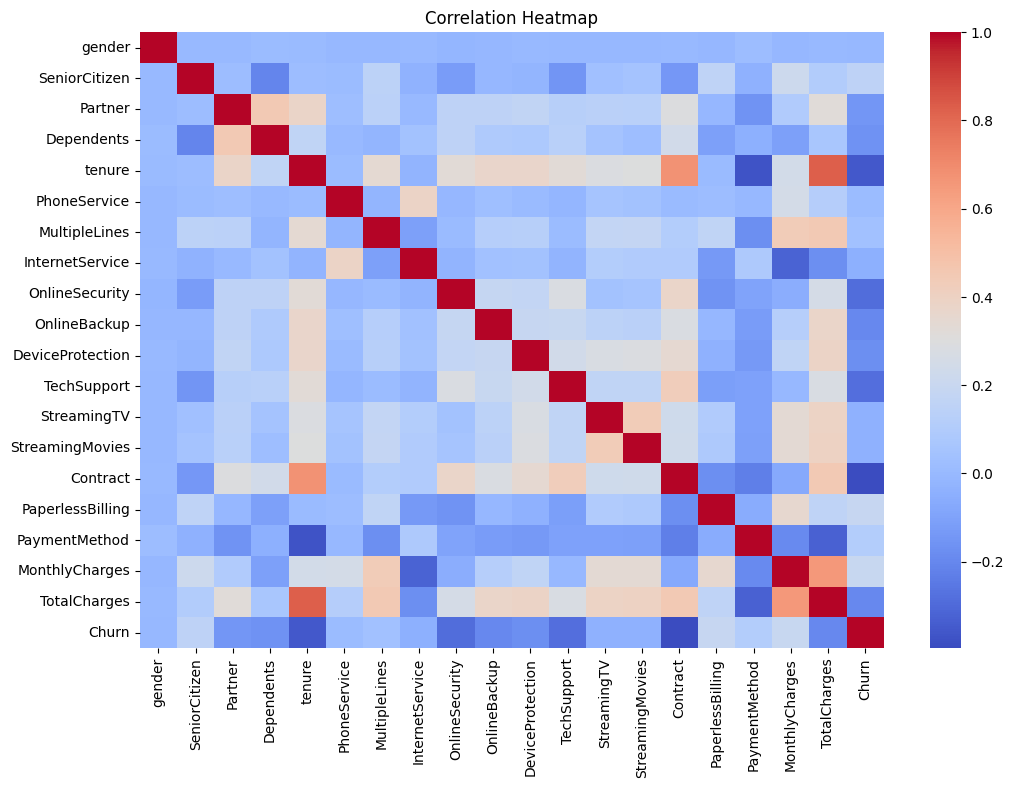

In [4]:
# EDA - Correlation 
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

In [5]:
# Feature Engineering
df['TenureBucket'] = pd.cut(df['tenure'], bins=5, labels=False)
df['MonthlyBucket'] = pd.cut(df['MonthlyCharges'], bins=5, labels=False)
df['TotalBucket'] = pd.cut(df['TotalCharges'], bins=5, labels=False)

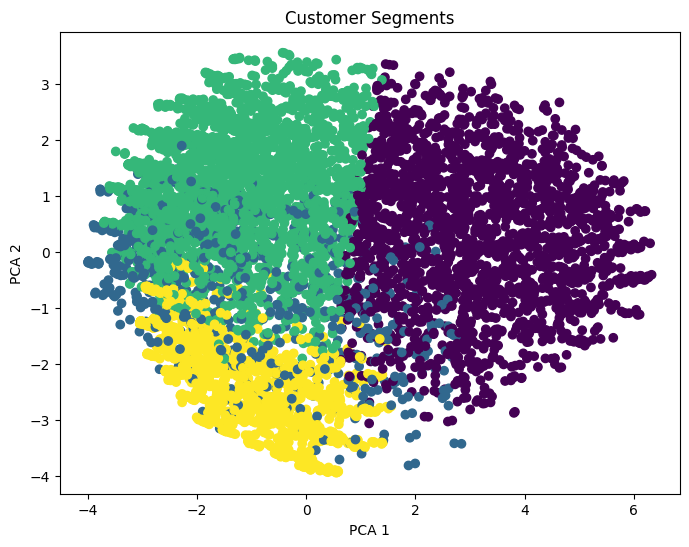

In [6]:
# Customer Segmentation using KMeans
features_for_segmentation = df.drop(['Churn'], axis=1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_segmentation)
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)
kmeans = KMeans(n_clusters=4, random_state=42)
df['Segment'] = kmeans.fit_predict(features_scaled)
plt.figure(figsize=(8,6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=df['Segment'], cmap='viridis')
plt.title('Customer Segments')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [7]:
# Churn Prediction
X = df.drop(['Churn'], axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Pipelines for model comparison
models = {
   "Random Forest": RandomForestClassifier(random_state=42),
   "Gradient Boosting": GradientBoostingClassifier(random_state=42),
   "Logistic Regression": LogisticRegression(max_iter=1000)
}
results = {}
for name, model in models.items():
   pipe = Pipeline([
       ('scaler', StandardScaler()),
       ('clf', model)
   ])
   pipe.fit(X_train, y_train)
   y_pred = pipe.predict(X_test)
   auc = roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1])
   results[name] = auc
   print(f"\n{name} AUC: {auc:.4f}")
   print(classification_report(y_test, y_pred))


Random Forest AUC: 0.8131
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1033
           1       0.65      0.45      0.53       374

    accuracy                           0.79      1407
   macro avg       0.73      0.68      0.70      1407
weighted avg       0.77      0.79      0.78      1407


Gradient Boosting AUC: 0.8357
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.65      0.49      0.56       374

    accuracy                           0.80      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.80      0.79      1407


Logistic Regression AUC: 0.8300
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69    

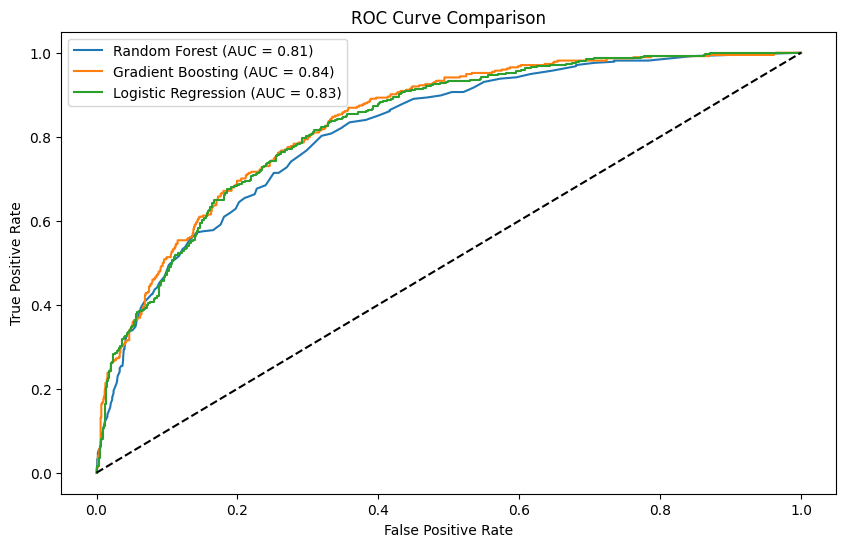

In [8]:
# ROC Curves
plt.figure(figsize=(10, 6))
for name, model in models.items():
   pipe = Pipeline([
       ('scaler', StandardScaler()),
       ('clf', model)
   ])
   pipe.fit(X_train, y_train)
   y_prob = pipe.predict_proba(X_test)[:, 1]
   fpr, tpr, _ = roc_curve(y_test, y_prob)
   plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
